In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import math
import copy

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Amsterdam
amsterdam_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekdays.csv')
amsterdam_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekends.csv')

#Athens
athens_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekdays.csv')
athens_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekends.csv')

#Barcelona
barcelona_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv')
barcelona_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekends.csv')

#Berlin
berlin_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekdays.csv')
berlin_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekends.csv')

#Budapest
budapest_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekdays.csv')
budapest_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekends.csv')

#Lisbon
lisbon_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekdays.csv')
lisbon_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekends.csv')

#London
london_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekdays.csv')
london_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekends.csv')

#Paris
paris_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekdays.csv')
paris_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekends.csv')

#Rome
rome_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekdays.csv')
rome_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekends.csv')

#Vienna
vienna_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekdays.csv')
vienna_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekends.csv')

In [3]:
datasets = [
    (amsterdam_weekdays, "Amsterdam", True),
    (amsterdam_weekend, "Amsterdam", False),
    (athens_weekdays, "Athens", True),
    (athens_weekend, "Athens", False),
    (barcelona_weekdays, "Barcelona", True),
    (barcelona_weekend, "Barcelona", False),
    (berlin_weekdays, "Berlin", True),
    (berlin_weekend, "Berlin", False),
    (budapest_weekdays, "Budapest", True),
    (budapest_weekend, "Budapest", False),
    (lisbon_weekdays, "Lisbon", True),
    (lisbon_weekend, "Lisbon", False),
    (london_weekdays, "London", True),
    (london_weekend, "London", False),
    (paris_weekdays, "Paris", True),
    (paris_weekend, "Paris", False),
    (rome_weekdays, "Rome", True),
    (rome_weekend, "Rome", False),
    (vienna_weekdays, "Vienna", True),
    (vienna_weekend, "Vienna", False)
]

df = pd.DataFrame()

for data, city, is_weekday in datasets:
    data['city'] = city
    data['weekday'] = is_weekday
    df = pd.concat([df, data], ignore_index=True)

df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

print(df.head())
print(df.shape)

      realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378

In [4]:
# path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
# df = pd.read_csv(path, index_col=0)
# df.head()

# Data Preposessing

## Add data shuffle

In [5]:
np.random.seed(144)
df = df.sample(frac=1).reset_index(drop=True)

## DEALING WITH MISSING VALUES

In [6]:
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


In [7]:
df.shape

(51707, 21)

In [8]:
df_complete = df.dropna()
df_complete.shape

(51707, 21)

## FINDING OUTLIERS

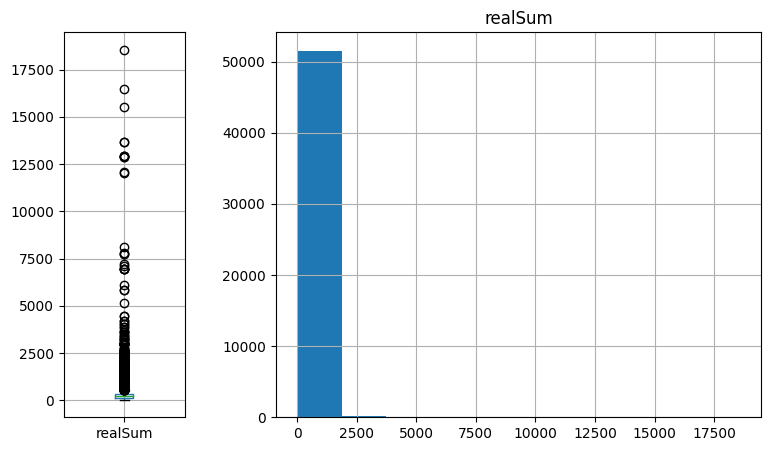

In [9]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='realSum',ax=axes[0]);
df.hist(column='realSum', ax=axes[1]);

In [10]:
Q1 = df['realSum'].quantile(0.25)
Q3 = df['realSum'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(148.75217370869953, 319.69428651318856, 170.94211280448903)

In [11]:
small_outliers = df['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 3662)

In [12]:
df['realSum'][small_outliers | big_outliers].head()

60     698.806972
66     956.983937
83     593.852160
95     636.702364
99    2311.738714
Name: realSum, dtype: float64

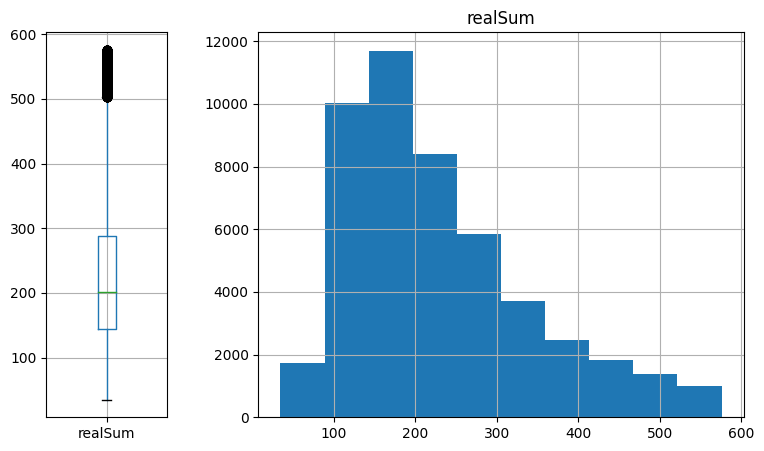

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [14]:
df_clean = df[~(small_outliers | big_outliers)]
df_clean.shape

(48045, 21)

In [15]:
df_clean.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

In [16]:
# df_clean.to_csv('out.csv', index=False) 

In [17]:
# Identifying categorical and numerical columns
categorical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['object', 'bool']]
numerical_cols = [col for col in df_clean.columns if df_clean[col].dtype in ['int64', 'float64'] and col != 'realSum']

# Adjust transformers if necessary
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Update preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df_clean.drop('realSum', axis=1))

# Check transformed feature names and dimensions
transformed_features = preprocessor.transformers_[0][1].get_feature_names_out(numerical_cols).tolist() + \
                       preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

print(transformed_features)
print(df_transformed.shape)

['person_capacity', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'room_shared_False', 'room_shared_True', 'room_private_False', 'room_private_True', 'host_is_superhost_False', 'host_is_superhost_True', 'city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin', 'city_Budapest', 'city_Lisbon', 'city_London', 'city_Paris', 'city_Rome', 'city_Vienna', 'weekday_False', 'weekday_True']
(48045, 35)


# Prepare Training Data

In [18]:
# y = df_clean['realSum'].values

# # Create Train Data and Test Data
# X_train, X_test, y_train, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
y = df_clean['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define SVM Model

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [21]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [22]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [23]:
model = SVR(X_train.shape[1]).to(device)
print(model)

SVR(
  (linear): Linear(in_features=35, out_features=1, bias=True)
)


In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [25]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

# Model Training

In [26]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SVR(n_features=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'SVR_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [27]:
cross_validate_model(df_transformed, y, n_splits=5, epochs=1000, batch_size=32, lr=0.01, epsilon=0.001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 188.03261556664938
Fold 1, Epoch 2, Validation MAE Loss: 148.38962896829818
Fold 1, Epoch 3, Validation MAE Loss: 116.16480100006483
Fold 1, Epoch 4, Validation MAE Loss: 95.6559299136593
Fold 1, Epoch 5, Validation MAE Loss: 83.9156281562267
Fold 1, Epoch 6, Validation MAE Loss: 77.26063271676851
Fold 1, Epoch 7, Validation MAE Loss: 73.06994492780123
Fold 1, Epoch 8, Validation MAE Loss: 70.27996894234938
Fold 1, Epoch 9, Validation MAE Loss: 68.26384301403252
Fold 1, Epoch 10, Validation MAE Loss: 66.72892029948254
Fold 1, Epoch 11, Validation MAE Loss: 65.51968217588559
Fold 1, Epoch 12, Validation MAE Loss: 64.54438859298516
Fold 1, Epoch 13, Validation MAE Loss: 63.749716430284174
Fold 1, Epoch 14, Validation MAE Loss: 63.096124546161825
Fold 1, Epoch 15, Validation MAE Loss: 62.55263028599909
Fold 1, Epoch 16, Validation MAE Loss: 62.111653941300894
Fold 1, Epoch 17, Validation MAE Loss: 61.74503288427329
Fold 1, Epoch 18, Va

57.12753614845118

In [28]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed,
#         y=y,
#         n_splits=5,
#         epochs=20,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

# Test Results

In [29]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SVR(n_features=input_features).to(device)
    model.load_state_dict(torch.load('SVR_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [30]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += epsilon_insensitive_loss(output, target, 0.1).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 56.386326998274846


In [31]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 6287.51220703125, RMSE: 79.29383087158203, MAE: 56.563514709472656, R²: 0.5048080478063935


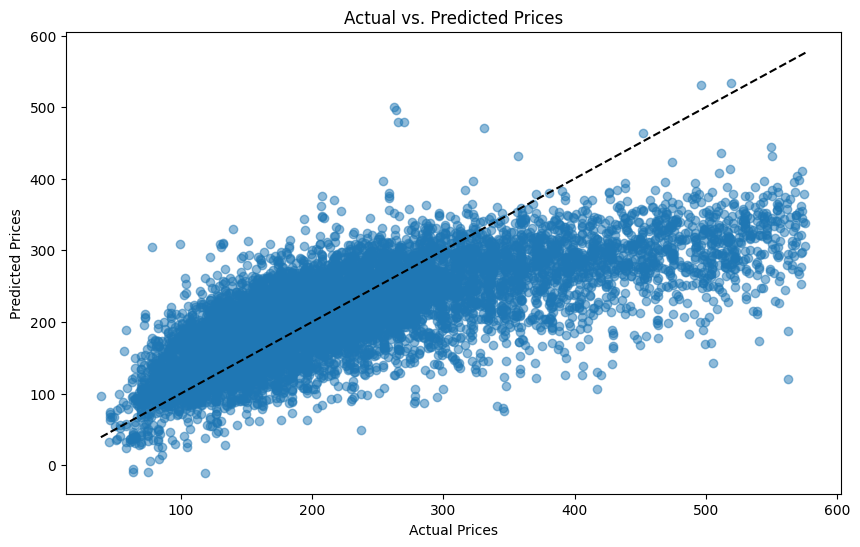

In [32]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# *MLP* Model

In [33]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.output(x)
        return x

In [34]:
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.01):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MLP(input_dim=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')
            
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'MLP_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [36]:
cross_validate_model(df_transformed, y, n_splits=5, epochs=1000, batch_size=32, lr=0.01, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 58.44988836391338
Fold 1, Epoch 2, Validation MAE Loss: 55.33266517037673
Fold 1, Epoch 3, Validation MAE Loss: 54.40915004049594
Fold 1, Epoch 4, Validation MAE Loss: 48.50666058014043
Fold 1, Epoch 5, Validation MAE Loss: 48.699325181636574
Fold 1, Epoch 6, Validation MAE Loss: 59.48533356535979
Fold 1, Epoch 7, Validation MAE Loss: 55.14001680112973
Fold 1, Epoch 8, Validation MAE Loss: 48.545419914593836
Fold 1, Epoch 9, Validation MAE Loss: 48.60624122619629
Fold 1, Epoch 10, Validation MAE Loss: 49.7615284108522
Fold 1, Epoch 11, Validation MAE Loss: 53.87593377774187
Fold 1, Epoch 12, Validation MAE Loss: 48.01578987089925
Fold 1, Epoch 13, Validation MAE Loss: 47.717323081621984
Fold 1, Epoch 14, Validation MAE Loss: 54.78765745677394
Fold 1, Epoch 15, Validation MAE Loss: 48.55099719193961
Fold 1, Epoch 16, Validation MAE Loss: 49.30595871224938
Fold 1, Epoch 17, Validation MAE Loss: 48.185963056888816
Fold 1, Epoch 18, Val

50.603358351838054

In [37]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed,
#         y=y,
#         n_splits=5,
#         epochs=20,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

In [38]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_dim=X_train.shape[1]).to(device)
    model.load_state_dict(torch.load('MLP_best_model.pth', map_location=device))
    return model, device

In [39]:
best_model, device = load_best_model(df_transformed.shape[1])

In [40]:
evaluate_model(best_model, test_loader, device)

Test Loss: 46.61187984138135


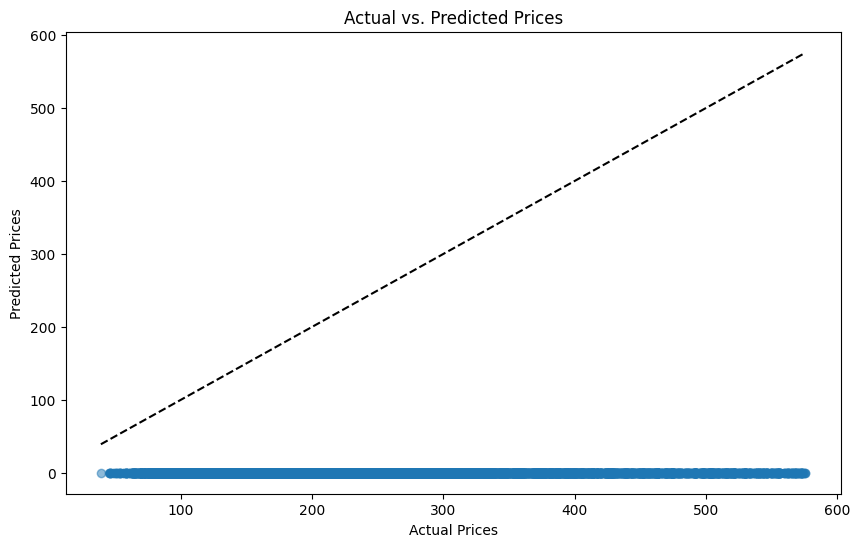

In [41]:
plot_predictions(model, test_loader, device)